In [10]:
# Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# SQL and databases
from sqlalchemy import create_engine

# Graph style
sns.set(style="whitegrid")


In [11]:
# Load data
ev_df = pd.read_csv("Electric_Vehicle_Population_Data.csv")

# Analyzing dataset
print(f"{ev_df.dtypes}\n")
print(f"{ev_df.columns}\n")
print(f"{ev_df.count()}\n")
print(f"{ev_df.isna().sum()}\n")

VIN (1-10)                                            object
County                                                object
City                                                  object
State                                                 object
Postal Code                                          float64
Model Year                                             int64
Make                                                  object
Model                                                 object
Electric Vehicle Type                                 object
Clean Alternative Fuel Vehicle (CAFV) Eligibility     object
Electric Range                                       float64
Base MSRP                                            float64
Legislative District                                 float64
DOL Vehicle ID                                         int64
Vehicle Location                                      object
Electric Utility                                      object
2020 Census Tract       

In [12]:
# Rename columns to simplified
ev_df = ev_df.rename(columns={
    'VIN (1-10)': 'VIN',
    'Model Year': 'Model_Year',
    'Electric Vehicle Type': 'EV_Type',
    'Clean Alternative Fuel Vehicle (CAFV) Eligibility': 'CAFV_Eligibility',
    'Electric Range': 'Electric_Range',
    'Base MSRP': 'Base_MSRP',
    'Legislative District': 'District',
    'DOL Vehicle ID': 'DOL_ID',
    'Vehicle Location': 'Vehicle_Location',
    'Electric Utility': 'Utility',
    '2020 Census Tract': 'Census_Tract'
})

# Drop rows with missing values
ev_df = ev_df.dropna(subset=['Model_Year', 'Model', 'County'])

# Convert columns to numeric type
ev_df['Model_Year'] = pd.to_numeric(ev_df['Model_Year'], errors='coerce')
ev_df['Electric_Range'] = pd.to_numeric(ev_df['Electric_Range'], errors='coerce')
ev_df['Base_MSRP'] = pd.to_numeric(ev_df['Base_MSRP'], errors='coerce')

print(ev_df.columns)

Index(['VIN', 'County', 'City', 'State', 'Postal Code', 'Model_Year', 'Make',
       'Model', 'EV_Type', 'CAFV_Eligibility', 'Electric_Range', 'Base_MSRP',
       'District', 'DOL_ID', 'Vehicle_Location', 'Utility', 'Census_Tract'],
      dtype='object')


In [13]:
# Create a SQLite engine
engine = create_engine('sqlite:///ev_population.db')  

# SQL queries to get insights
registration_query = """
                SELECT Model_Year AS Year, COUNT(*) AS Total_Registrations
                FROM ev_population
                GROUP BY Model_Year
                ORDER BY Model_Year;
                """

top10_query = """
            SELECT Make, Model, COUNT(*) AS Registration_Count
            FROM ev_population
            GROUP BY Make, Model
            ORDER BY Registration_Count DESC
            LIMIT 10;
            """

CAFVRegion_query ="""
            SELECT County, COUNT(*) AS CAFV_Count
            FROM ev_population
            WHERE CAFV_Eligibility LIKE '%Eligible%'
            GROUP BY County
            ORDER BY CAFV_Count DESC;
            """

CountyVariation_query ="""
            SELECT County, Model_Year AS Year, COUNT(*) AS Total_Registrations
            FROM ev_population
            GROUP BY County, Model_Year
            ORDER BY County, Model_Year;
            """

# Execute SQL queries and load results into DataFrames
with engine.begin() as connection:
    ev_df.to_sql('ev_population', con=connection, if_exists='replace', index=False)
    registrations_per_year = pd.read_sql(registration_query, connection)
    top_models = pd.read_sql(top10_query, connection)
    cafv_county = pd.read_sql(CAFVRegion_query, connection)
    by_year_county = pd.read_sql(CountyVariation_query, connection)

# Display all rows and columns temporarily
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print(f"{registrations_per_year}\n")
print(f"{top_models}\n")
print(f"{cafv_county}\n")
print(f"{by_year_county}\n")

# Reset display settings
pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows')

    Year  Total_Registrations
0   2000                    8
1   2002                    2
2   2003                    1
3   2008                   18
4   2010                   23
5   2011                  663
6   2012                 1478
7   2013                 4185
8   2014                 3374
9   2015                 4634
10  2016                 5308
11  2017                 8738
12  2018                14553
13  2019                11046
14  2020                12336
15  2021                20673
16  2022                29358
17  2023                60619
18  2024                50578
19  2025                18036
20  2026                  502

         Make           Model  Registration_Count
0       TESLA         MODEL Y               51050
1       TESLA         MODEL 3               37107
2      NISSAN            LEAF               13949
3       TESLA         MODEL S                7884
4   CHEVROLET         BOLT EV                7517
5       TESLA         MODEL X          

C:\Users\Gianluca Nanni\AppData\Local\Temp\ipykernel_8328\4207958157.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Year', y='Total_Registrations', data=registrations_per_year, palette='Blues_d')


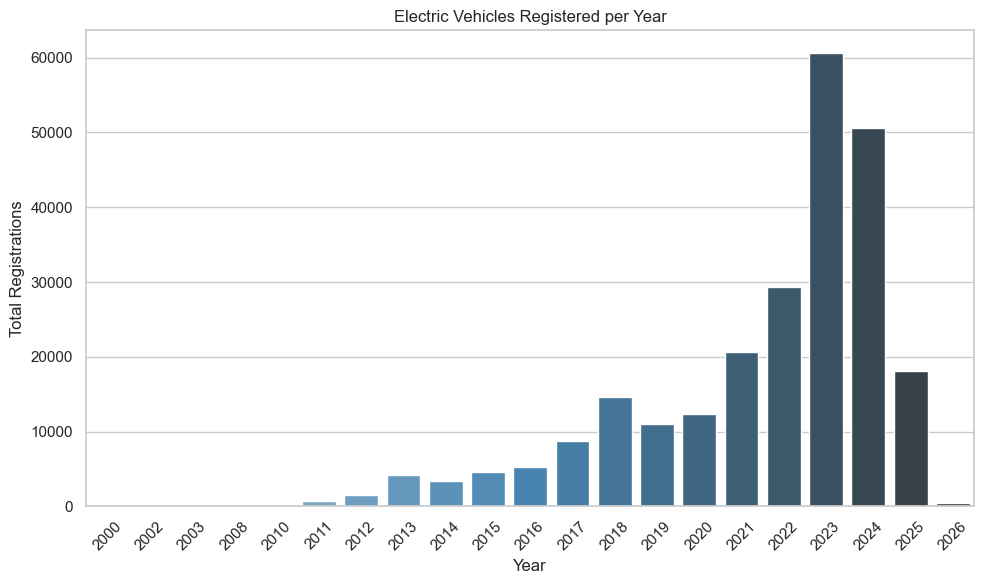

In [14]:
# Plot total electric vehicle registrations per year
plt.figure(figsize=(10, 6))
sns.barplot(x='Year', y='Total_Registrations', data=registrations_per_year, palette='Blues_d')
plt.title('Electric Vehicles Registered per Year')
plt.xlabel('Year')
plt.ylabel('Total Registrations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


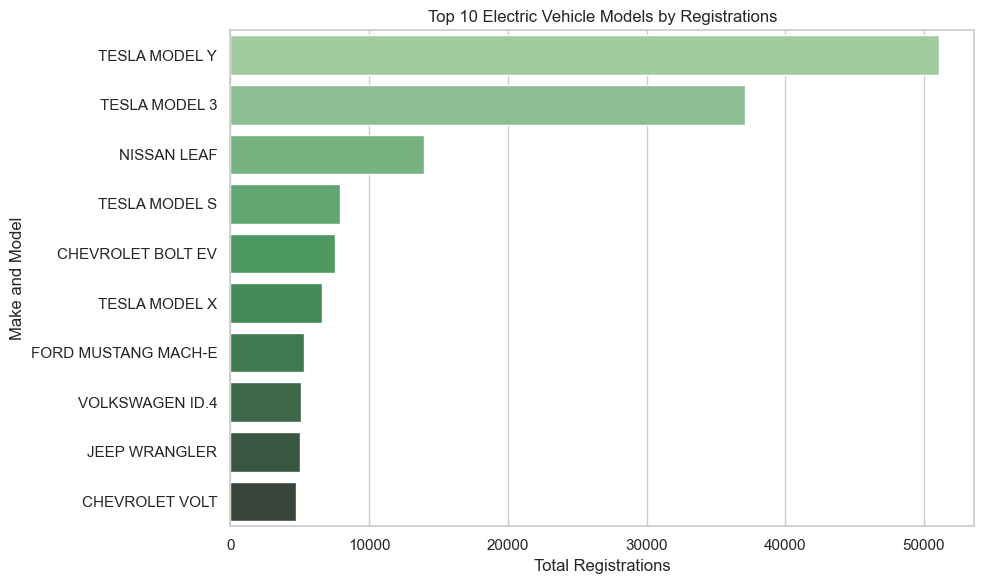

In [15]:
# Create a full name
top_models['Full_Name'] = top_models['Make'] + ' ' + top_models['Model']

# Plot top 10 registered electric vehicle
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Registration_Count',
    y='Full_Name',
    data=top_models,
    palette='Greens_d',
    hue='Full_Name',
    legend=False
)

plt.title('Top 10 Electric Vehicle Models by Registrations')
plt.xlabel('Total Registrations')
plt.ylabel('Make and Model')
plt.tight_layout()
plt.show()


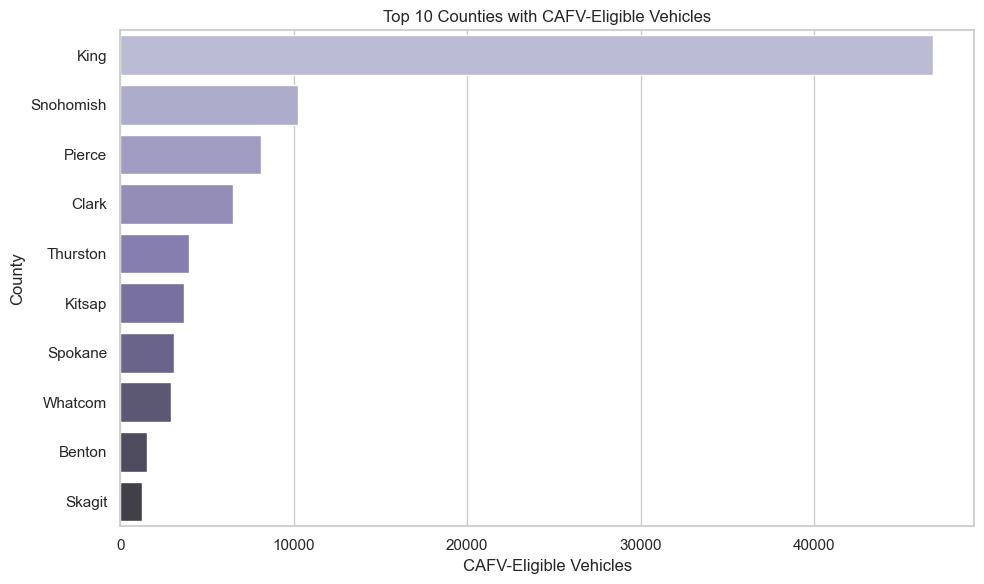

In [16]:
# Top 10 counties
top_cafv = cafv_county.head(10)

# Plot CAFV-eligible vehicle counts by county
plt.figure(figsize=(10, 6))
sns.barplot(
    x='CAFV_Count',
    y='County',
    data=top_cafv,
    palette='Purples_d',
    hue='County',
    legend=False
)
plt.title('Top 10 Counties with CAFV-Eligible Vehicles')
plt.xlabel('CAFV-Eligible Vehicles')
plt.ylabel('County')
plt.tight_layout()
plt.show()


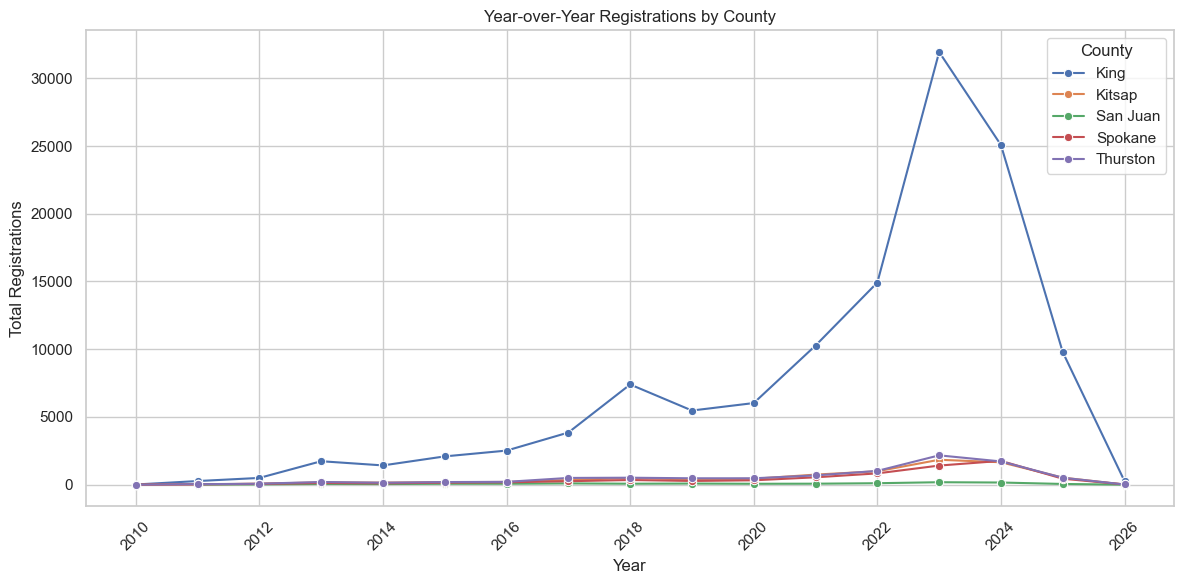

In [17]:
# Top 5 most frequent counties for readability
main_counties = by_year_county['County'].value_counts().head(5).index
filtered = by_year_county[by_year_county['County'].isin(main_counties)]

# Keep only records from 2010 onward
filtered = filtered[filtered['Year'] >= 2010]

# Plot registrations over time for selected counties
plt.figure(figsize=(12, 6))
sns.lineplot(x='Year', y='Total_Registrations', hue='County', data=filtered, marker="o")
plt.title('Year-over-Year Registrations by County')
plt.xlabel('Year')
plt.ylabel('Total Registrations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title='County')
plt.show()
